In [2]:
#pip install regionmask

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
import seaborn as sns
import warnings

import geopandas as gp
from shapely.geometry import MultiPolygon, Polygon

import regionmask
from xmip.regionmask import merged_mask

import gcsfs
fs = gcsfs.GCSFileSystem()

%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

# Make regional masks

In [5]:
#from this webpage: https://www.marineregions.org

bering_1x1 = gp.read_file('/home/jovyan/mCDR/shapefiles/bering.zip')
gulf_1x1 = gp.read_file('/home/jovyan/mCDR/shapefiles/gulf.zip')
caribbean_1x1 = gp.read_file('/home/jovyan/mCDR/shapefiles/caribbean.zip')

lon = np.arange(-179.5, 180, 1)
lat = np.arange(-89.5, 90, 1)

mask_bering_1x1 = regionmask.mask_geopandas(bering_1x1, lon, lat)
mask_gulf_1x1 = regionmask.mask_geopandas(gulf_1x1, lon, lat)
mask_caribbean_1x1 = regionmask.mask_geopandas(caribbean_1x1, lon, lat)

mask_bering_1x1 = mask_bering_1x1.to_dataset().rename({"lon":"xlon", "lat": "ylat"})
mask_gulf_1x1  = mask_gulf_1x1.to_dataset().rename({"lon":"xlon", "lat": "ylat"})
mask_caribbean_1x1 = mask_caribbean_1x1.to_dataset().rename({"lon":"xlon", "lat": "ylat"})

## Define members of the LR-CMIP6-testbed

In [3]:
regridded_members_path = 'gs://leap-persistent/abbysh/pco2_all_members_1982-2016/post00_regridded_members'

mems_dict = dict()
a = fs.ls(regridded_members_path)
for ens_path in a:
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:
        memo = mem.split('/')[-1]
        
        if ens not in mems_dict:
            mems_dict[ens] = [memo]

        elif ens in mems_dict:
            mems_dict[ens].append(memo)

## Figure 9

In [4]:
datasets_ens_1x1_short = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):
        truth_path = f'gs://leap-persistent/hatlenheimdalthea/pco2_residual_testbed_2020-2021/00_regridded_members/{ens}/{member}/{ens}.{member.split("_")[-1]}.Omon.zarr'
        recon_path = f"gs://leap-persistent/hatlenheimdalthea/pco2_residual_testbed_2020-2021_unmasked/post02_xgb_2020-2022/reconstructions/{ens}/{member}/recon_pCO2_{ens}_{member}_mon_1x1_202002_202201.zarr"
        kwargs = dict(chunks={'time':-1})
                    
        truth = xr.open_dataset(truth_path, engine='zarr',**kwargs).spco2 
        unseen = xr.open_dataset(recon_path, engine='zarr',**kwargs).pCO2_recon_unseen 

        truth = truth.assign_coords(status='truth')
        unseen = unseen.assign_coords(status='unseen')
        
        truth = truth.assign_coords(time=unseen['time'].data)
        
        member_ds = xr.concat([truth, unseen], dim='status')

        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
        
    datasets_ens_1x1_short.append(ds_ens)

In [8]:
concat_testbed_mean_short = xr.concat(datasets_ens_1x1_short, dim='ensemble', join='outer') 

In [11]:
concat_testbed_mean_short_bering = concat_testbed_mean_short.where(mask_bering_1x1.mask.values==0.)
concat_testbed_mean_short_gulf = concat_testbed_mean_short.where(mask_gulf_1x1.mask.values==0.)
concat_testbed_mean_short_caribbean = concat_testbed_mean_short.where(mask_caribbean_1x1.mask.values==0.)

In [17]:
rmse_short_bering = np.sqrt(((concat_testbed_mean_short_bering.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_short_gulf = np.sqrt(((concat_testbed_mean_short_gulf.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_short_caribbean = np.sqrt(((concat_testbed_mean_short_caribbean.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))

In [18]:
rmse_short_df_bering = rmse_short_bering.to_dataframe()
rmse_short_df_reset_bering = rmse_short_df_bering.reset_index()
rmse_short_index_bering = rmse_short_df_reset_bering.set_index(['ensemble','n_member','member'])
rmse_short_all_bering = rmse_short_index_bering
rmse_short_all_bering = rmse_short_all_bering.squeeze()

rmse_short_df_gulf = rmse_short_gulf.to_dataframe()
rmse_short_df_reset_gulf = rmse_short_df_gulf.reset_index()
rmse_short_index_gulf = rmse_short_df_reset_gulf.set_index(['ensemble','n_member','member'])
rmse_short_all_gulf = rmse_short_index_gulf
rmse_short_all_gulf = rmse_short_all_gulf.squeeze()

rmse_short_df_caribbean = rmse_short_caribbean.to_dataframe()
rmse_short_df_reset_caribbean = rmse_short_df_caribbean.reset_index()
rmse_short_index_caribbean = rmse_short_df_reset_caribbean.set_index(['ensemble','n_member','member'])
rmse_short_all_caribbean = rmse_short_index_caribbean
rmse_short_all_caribbean = rmse_short_all_caribbean.squeeze()

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_890/1439179946.py:15: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel(f'Mean 2020-2021 RMSE ($\mu atm$)', fontsize = 18)


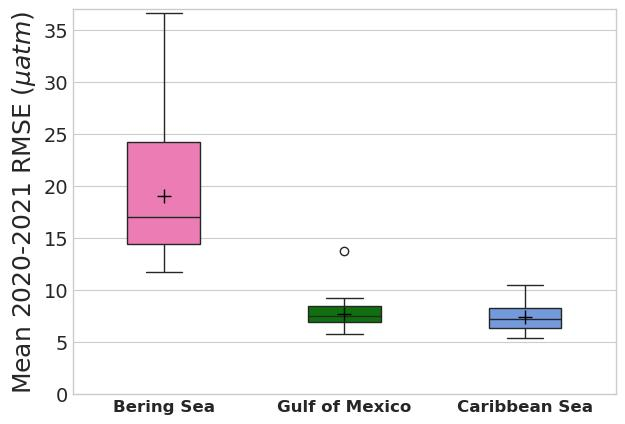

In [19]:
colors = ['hotpink','green', 'cornflowerblue']
labels = ['Bering Sea', 'Gulf of Mexico', 'Caribbean Sea']

with plt.style.context('seaborn-v0_8-whitegrid'):
    fig = plt.figure(figsize=(7,5))

    sns.boxplot(data=[rmse_short_all_bering.tolist(), 
                  rmse_short_all_gulf.tolist(), 
                  rmse_short_all_caribbean.tolist()], 
            palette=colors, 
            showmeans=True, 
            width=0.4,
            meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})

    plt.ylabel(f'Mean 2020-2021 RMSE ($\mu atm$)', fontsize = 18)
    plt.xticks(ticks = [0,1,2], fontsize = 12, labels = labels, weight='bold')
    plt.yticks(fontsize = 14)
    plt.ylim(0, 37)
#plt.savefig("/home/jovyan/boxplot_1x1resolution.jpg",dpi=300, bbox_inches="tight")

## Inset Figure 9

In [13]:
rmse_timeline_SOCAT_short_IQR_caribbean = np.sqrt(((concat_testbed_mean_short_caribbean.diff('status'))**2).sel(time=slice("1982-01-01",'2022-12-31')).mean(['status', 'xlon', 'ylat']))
rmse_timeline_SOCAT_short_IQR_bering = np.sqrt(((concat_testbed_mean_short_bering.diff('status'))**2).sel(time=slice("1982-01-01",'2022-12-31')).mean(['status', 'xlon', 'ylat']))
rmse_timeline_SOCAT_short_IQR_gulf = np.sqrt(((concat_testbed_mean_short_gulf.diff('status'))**2).sel(time=slice("1982-01-01",'2022-12-31')).mean(['status', 'xlon', 'ylat']))

In [14]:
rmse_SOCAT_short_IQR_caribbean  = rmse_timeline_SOCAT_short_IQR_caribbean.to_dataframe()
rmse_SOCAT_short_stats_caribbean  = rmse_SOCAT_short_IQR_caribbean.groupby(['time']).describe()
rmse_SOCAT_short_stats_xr_caribbean  = rmse_SOCAT_short_stats_caribbean.to_xarray()

rmse_SOCAT_short_IQR_bering  = rmse_timeline_SOCAT_short_IQR_bering.to_dataframe()
rmse_SOCAT_short_stats_bering  = rmse_SOCAT_short_IQR_bering.groupby(['time']).describe()
rmse_SOCAT_short_stats_xr_bering  = rmse_SOCAT_short_stats_bering.to_xarray()

rmse_SOCAT_short_IQR_gulf  = rmse_timeline_SOCAT_short_IQR_gulf.to_dataframe()
rmse_SOCAT_short_stats_gulf  = rmse_SOCAT_short_IQR_gulf.groupby(['time']).describe()
rmse_SOCAT_short_stats_xr_gulf  = rmse_SOCAT_short_stats_gulf.to_xarray()

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_143/1532046076.py:21: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Reconstruction RMSE ($\mu atm$)', fontsize=16)


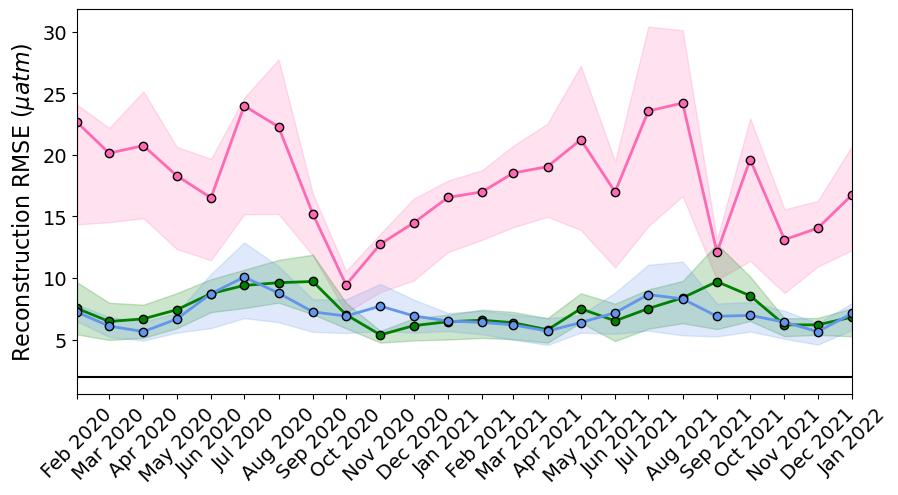

In [16]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(10,5))

plt.plot(rmse_SOCAT_short_stats_xr_bering.time, rmse_SOCAT_short_stats_xr_bering[('spco2', 'mean')], label='Bering Sea', color='hotpink', linewidth=2.0, marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.fill_between(rmse_SOCAT_short_stats_xr_bering.time, rmse_SOCAT_short_stats_xr_bering[('spco2', '25%')], rmse_SOCAT_short_stats_xr_bering[('spco2', '75%')], alpha=0.2, color = 'hotpink')
plt.plot(rmse_SOCAT_short_stats_xr_gulf.time, rmse_SOCAT_short_stats_xr_gulf[('spco2', 'mean')], label='Gulf of Mexico', color='green', linewidth=2.0, marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.fill_between(rmse_SOCAT_short_stats_xr_gulf.time, rmse_SOCAT_short_stats_xr_gulf[('spco2', '25%')], rmse_SOCAT_short_stats_xr_gulf[('spco2', '75%')], alpha=0.2, color = 'green')
plt.plot(rmse_SOCAT_short_stats_xr_caribbean.time, rmse_SOCAT_short_stats_xr_caribbean[('spco2', 'mean')], label='Caribbean Sea', color='cornflowerblue', linewidth=2.0, marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.fill_between(rmse_SOCAT_short_stats_xr_caribbean.time, rmse_SOCAT_short_stats_xr_caribbean[('spco2', '25%')], rmse_SOCAT_short_stats_xr_caribbean[('spco2', '75%')], alpha=0.2, color = 'cornflowerblue')

plt.axhline(2,zorder=-10,c='black')
plt.ylabel('Reconstruction RMSE ($\mu atm$)', fontsize=16)
plt.xlim(rmse_SOCAT_short_stats_xr_gulf.time[0],rmse_SOCAT_short_stats_xr_gulf.time[-1])

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.xticks(rotation=45); 
plt.tick_params(axis='both', labelsize=14)
#plt.savefig("/home/jovyan/timeseries_resolution.jpg",dpi=300, bbox_inches="tight")

## Figure S5

In [33]:
rmse_map_testbed_mean_short_esm = np.sqrt(((concat_testbed_mean_short.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['n_member','time','status']))
filtered_esm = rmse_map_testbed_mean_short_esm.where((rmse_map_testbed_mean_short_esm  >= 0) & (rmse_map_testbed_mean_short_esm  <= 3))

<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_890/1611360203.py:43: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('Mean 2020-2021 RMSE ($\mu atm$)', fontsize=14)


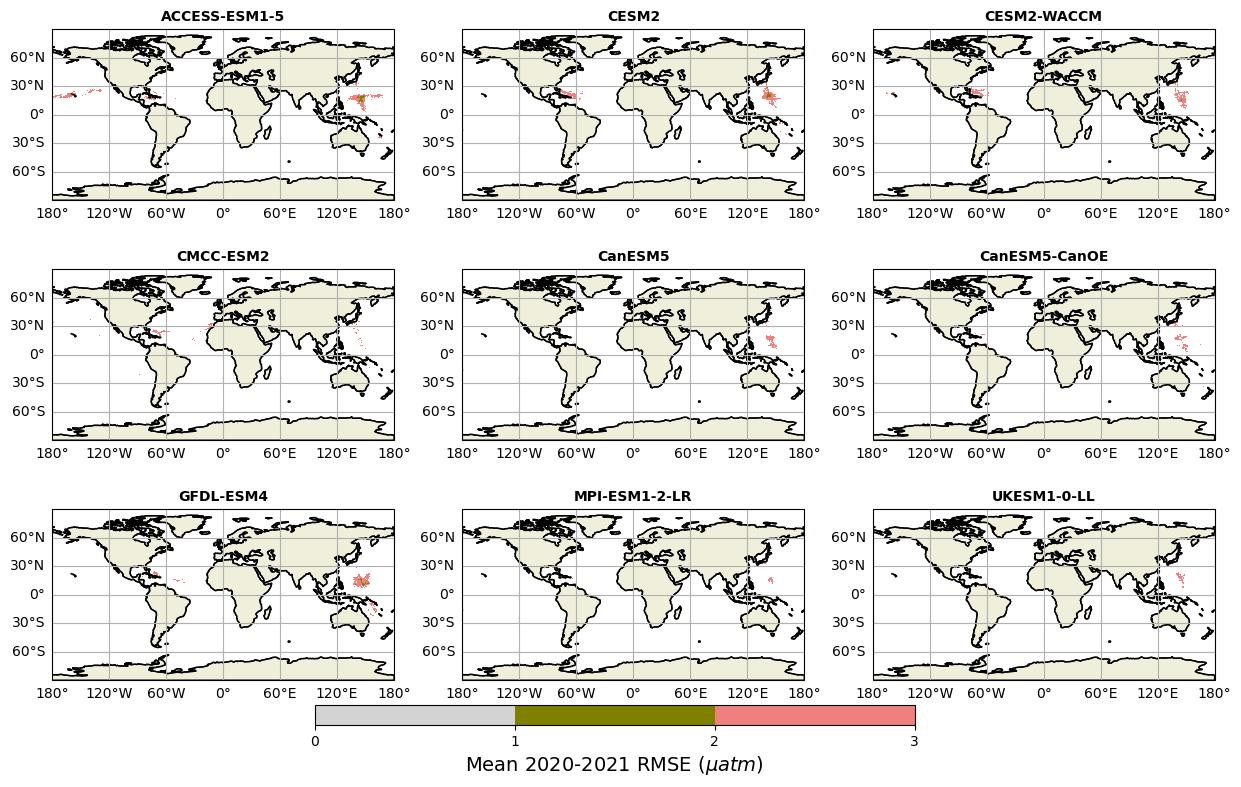

In [35]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import numpy as np
import matplotlib.colors as mcolors

fig, axes = plt.subplots(3, 3, figsize=(15, 10), 
                         subplot_kw={'projection': ccrs.PlateCarree()}, 
                         sharex=True, sharey=True)

colors = ['lightgray', 'olive', 'lightcoral'] 
cmap = mcolors.ListedColormap(colors)
bounds = [0, 1, 2, 3] 
norm = mcolors.BoundaryNorm(bounds, cmap.N)

img = None  

for ax, dataset_name in zip(axes.flat, filtered_esm.ensemble.values):
    dataset = filtered_esm.sel(ensemble=dataset_name)
    
    img = dataset.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=3, 
                       cmap=cmap, norm=norm, add_colorbar=False) 
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    ax.set_title(f'{dataset_name}', fontsize=10, fontweight='bold')

fig.subplots_adjust(bottom=0.2)

cbar_ax = fig.add_axes([0.3, 0.17, 0.4, 0.02])  # [x, y, width, height]
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal', ticks=bounds)
cbar.set_label('Mean 2020-2021 RMSE ($\mu atm$)', fontsize=14)
#plt.savefig("/home/jovyan/rmse_map.jpg", dpi=300, bbox_inches="tight")

## Figure S4

In [20]:
# Region mask for HR-CESM-testbed

#from this webpage: https://www.marineregions.org
bering = gp.read_file('/home/jovyan/mCDR/shapefiles/bering.zip')
caribbean = gp.read_file('/home/jovyan/mCDR/shapefiles/caribbean.zip')

lon = np.arange(-180, 180,.1)
lat = np.arange(-90, 90,.1)
mask_bering = regionmask.mask_geopandas(bering, lon, lat)
mask_bering  = mask_bering.to_dataset().rename({"lon":"longitude", "lat": "latitude"})

### Add time dimension to the region mask 

In [24]:
data_array = mask_bering.mask
latitudes = np.linspace(-90, 90, 1800)
longitudes = np.linspace(-180, 180, 3600)


data = xr.DataArray(data_array, dims=['latitude', 'longitude'], 
                    coords={'latitude': latitudes, 
                            'longitude': longitudes})

time_coord = np.arange(24)  

data_bering = xr.DataArray(
    np.tile(data.values[np.newaxis, :, :], (24, 1, 1)),  
    dims=['time', 'latitude', 'longitude'],
    coords={'time': time_coord, 'latitude': latitudes, 'longitude': longitudes}
)

In [19]:
# HR-CESM-testbed: Exp. HR-2yr
truth = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/pco2_components_202002-202201.zarr', engine='zarr').pCO2SURF 
unseen_global_2020_2022 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/2022_global/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').pco2_recon_unseen
truth = truth.assign_coords(status='truth')
unseen_global_2020_2022 = unseen_global_2020_2022.assign_coords(status='reconstruction')
truth = truth.assign_coords(time=unseen_global_2020_2022['time'].data)
CESM_ds_global_2020_2022 = xr.concat([truth, unseen_global_2020_2022], dim='status')

bias_global_2020_2022_timeseries = CESM_ds_global_2020_2022.diff('status').sel(time=slice("2020-02-01",'2022-01-01')).mean(['status'])
bias_bering_for_timeseries_global_2020_2022 = bias_global_2020_2022_timeseries.where(data_bering.values==0.)

In [ ]:
# LR-CMIP6-testbed
bias_timeline_SOCAT_short_bering = concat_testbed_mean_short_bering.diff('status').sel(time=slice("1982-01-01",'2022-12-31')).mean(['n_member','status', 'xlon', 'ylat'])

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_143/420226798.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Reconstruction bias ($\mu atm$)', fontsize=16)


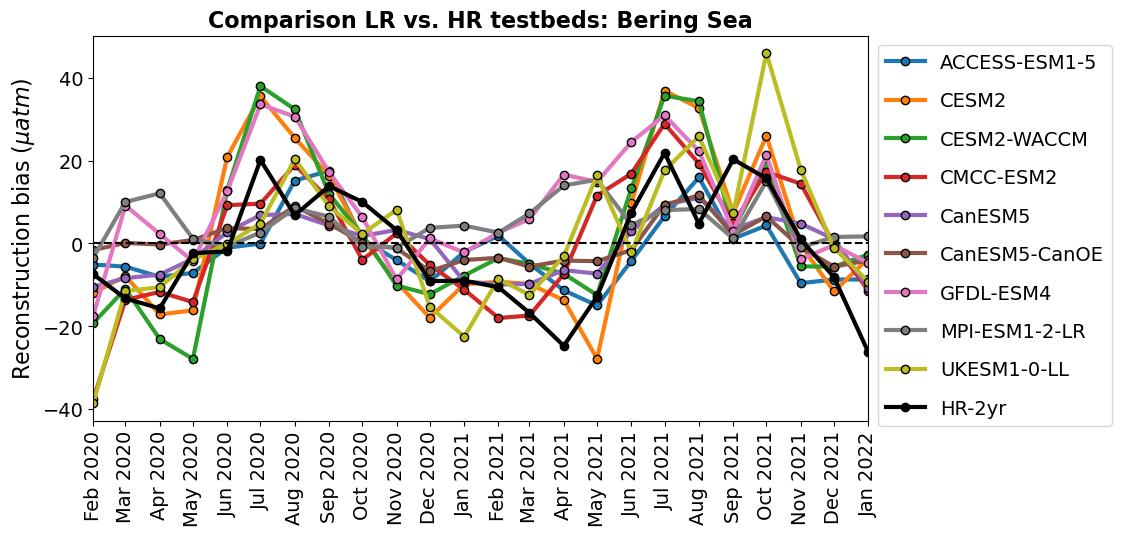

In [27]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(10, 5))

for ensemble in bias_timeline_SOCAT_short_bering.ensemble.values:
    ensemble_data = bias_timeline_SOCAT_short_bering.sel(ensemble=ensemble)
    
    plt.plot(ensemble_data.time.values, ensemble_data.values, label={ensemble}, linestyle='solid', linewidth=3.0, marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)

plt.plot(bias_bering_for_timeseries_global_2020_2022.time,bias_bering_for_timeseries_global_2020_2022.mean(['longitude', 'latitude']),linewidth=3.0,c='black',label='HR-2yr', linestyle='solid', marker='o',markersize=6, markeredgecolor='black', markeredgewidth=1)

plt.title('Comparison LR vs. HR testbeds: Bering Sea', fontsize=16, fontweight="bold")
plt.ylabel('Reconstruction bias ($\mu atm$)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(0, color='black', linestyle='--')
plt.xlim(bias_bering_for_timeseries_global_2020_2022.time[0],bias_bering_for_timeseries_global_2020_2022.time[-1])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', labelspacing=1, fontsize=14);
#plt.savefig("/home/jovyan/timeseries_bias_bering_comparison.jpg",dpi=300, bbox_inches="tight")

## Figure 10

In [20]:
datasets_ens_1x1_short = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):
        truth_path = f'gs://leap-persistent/hatlenheimdalthea/pco2_residual_testbed_2020-2021/00_regridded_members/{ens}/{member}/{ens}.{member.split("_")[-1]}.Omon.zarr'
        recon_path = f"gs://leap-persistent/hatlenheimdalthea/pco2_residual_testbed_2020-2021/post02_xgb_2020-2022/reconstructions/{ens}/{member}/recon_pCO2_{ens}_{member}_mon_1x1_202002_202201.zarr"
        kwargs = dict(chunks={'time':-1})
                    
        truth = xr.open_dataset(truth_path, engine='zarr',**kwargs).spco2 
        unseen = xr.open_dataset(recon_path, engine='zarr',**kwargs).pCO2_recon_unseen 

        truth = truth.assign_coords(status='truth')
        unseen = unseen.assign_coords(status='unseen')
        
        truth = truth.assign_coords(time=unseen['time'].data)
        
        member_ds = xr.concat([truth, unseen], dim='status')

        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
        
    datasets_ens_1x1_short.append(ds_ens)

In [21]:
datasets_ens_1x1_full = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):
        truth_path = f'gs://leap-persistent/abbysh/pco2_all_members_1982-2022/post00_regridded_members/{ens}/{member}/{ens}.{member.split("_")[-1]}.Omon.zarr'
        recon_path = f"gs://leap-persistent/abbysh/pco2_gridsearch_1982-2022/post02_xgb_1982-2022_nmse_outputs/reconstructions/{ens}/{member}/xg_recon_pCO2_{ens}_{member}_mon_1x1_198202_202212.zarr"
        kwargs = dict(chunks={'time':-1})
                    
        truth = xr.open_mfdataset(truth_path, engine='zarr',**kwargs).spco2 ## this is the testbed truth, RAW testbed pco2
        unseen = xr.open_mfdataset(recon_path, engine='zarr',**kwargs).pCO2_recon_unseen ## this is the reconstructed pco2 AFTER pco2-T is added back

        truth = truth.assign_coords(status='truth')
        unseen = unseen.assign_coords(status='unseen')

        truth = truth.assign_coords(time=unseen['time'].data)
        
        member_ds = xr.concat([truth, unseen], dim='status')
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
       
    datasets_ens_1x1_full.append(ds_ens)

In [22]:
datasets_ens_1x1_collapsed = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):
        truth_path = f'gs://leap-persistent/hatlenheimdalthea/pco2_residual_testbed_2020-2021/00_regridded_members/{ens}/{member}/{ens}.{member.split("_")[-1]}.Omon.zarr'
        recon_path = f"gs://leap-persistent/hatlenheimdalthea/pco2_residual_testbed_2020-2021_collapsed/post02_xgb_2020-2022/reconstructions/{ens}/{member}/recon_pCO2_{ens}_{member}_mon_1x1_202002_202201.zarr"
        kwargs = dict(chunks={'time':-1})
                    
        truth = xr.open_mfdataset(truth_path, engine='zarr',**kwargs).spco2 ## this is the testbed truth, RAW testbed pco2
        unseen = xr.open_mfdataset(recon_path, engine='zarr',**kwargs).pCO2_recon_unseen ## this is the reconstructed pco2 AFTER pco2-T is added back

        truth = truth.assign_coords(status='truth')
        unseen = unseen.assign_coords(status='unseen')

        truth = truth.assign_coords(time=unseen['time'].data)
        
        member_ds = xr.concat([truth, unseen], dim='status')
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens_1x1_collapsed.append(ds_ens)

In [23]:
concat_testbed_mean_short = xr.concat(datasets_ens_1x1_short, dim='ensemble', join='outer') 
concat_testbed_mean_full = xr.concat(datasets_ens_1x1_full, dim='ensemble', join='outer') 
concat_testbed_mean_collapsed = xr.concat(datasets_ens_1x1_collapsed, dim='ensemble', join='outer') 

In [24]:
concat_testbed_mean_short_bering = concat_testbed_mean_short.where(mask_bering_1x1.mask.values==0.)
concat_testbed_mean_short_gulf = concat_testbed_mean_short.where(mask_gulf_1x1.mask.values==0.)
concat_testbed_mean_short_caribbean = concat_testbed_mean_short.where(mask_caribbean_1x1.mask.values==0.)

concat_testbed_mean_full_bering = concat_testbed_mean_full.where(mask_bering_1x1.mask.values==0.)
concat_testbed_mean_full_gulf = concat_testbed_mean_full.where(mask_gulf_1x1.mask.values==0.)
concat_testbed_mean_full_caribbean = concat_testbed_mean_full.where(mask_caribbean_1x1.mask.values==0.)

concat_testbed_mean_collapsed_bering = concat_testbed_mean_collapsed.where(mask_bering_1x1.mask.values==0.)
concat_testbed_mean_collapsed_gulf = concat_testbed_mean_collapsed.where(mask_gulf_1x1.mask.values==0.)
concat_testbed_mean_collapsed_caribbean = concat_testbed_mean_collapsed.where(mask_caribbean_1x1.mask.values==0.)

In [25]:
rmse_short_global = np.sqrt(((concat_testbed_mean_short.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_short_bering = np.sqrt(((concat_testbed_mean_short_bering.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_short_gulf = np.sqrt(((concat_testbed_mean_short_gulf.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_short_caribbean = np.sqrt(((concat_testbed_mean_short_caribbean.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))

rmse_full_global = np.sqrt(((concat_testbed_mean_full.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_full_bering = np.sqrt(((concat_testbed_mean_full_bering.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_full_gulf = np.sqrt(((concat_testbed_mean_full_gulf.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_full_caribbean = np.sqrt(((concat_testbed_mean_full_caribbean.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))

rmse_collapsed_global = np.sqrt(((concat_testbed_mean_collapsed.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_collapsed_bering = np.sqrt(((concat_testbed_mean_collapsed_bering.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_collapsed_gulf = np.sqrt(((concat_testbed_mean_collapsed_gulf.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))
rmse_collapsed_caribbean = np.sqrt(((concat_testbed_mean_collapsed_caribbean.diff('status'))**2).sel(time=slice("2020-02-01",'2022-01-01')).mean(['time', 'status', 'ylat', 'xlon']))

In [26]:
rmse_short_df_global = rmse_short_global.to_dataframe()
rmse_short_df_reset_global = rmse_short_df_global.reset_index()
rmse_short_index_global = rmse_short_df_reset_global.set_index(['ensemble','n_member','member'])
rmse_short_all_global = rmse_short_index_global
rmse_short_all_global = rmse_short_all_global.squeeze()

rmse_short_df_bering = rmse_short_bering.to_dataframe()
rmse_short_df_reset_bering = rmse_short_df_bering.reset_index()
rmse_short_index_bering = rmse_short_df_reset_bering.set_index(['ensemble','n_member','member'])
rmse_short_all_bering = rmse_short_index_bering
rmse_short_all_bering = rmse_short_all_bering.squeeze()

rmse_short_df_gulf = rmse_short_gulf.to_dataframe()
rmse_short_df_reset_gulf = rmse_short_df_gulf.reset_index()
rmse_short_index_gulf = rmse_short_df_reset_gulf.set_index(['ensemble','n_member','member'])
rmse_short_all_gulf = rmse_short_index_gulf
rmse_short_all_gulf = rmse_short_all_gulf.squeeze()

rmse_short_df_caribbean = rmse_short_caribbean.to_dataframe()
rmse_short_df_reset_caribbean = rmse_short_df_caribbean.reset_index()
rmse_short_index_caribbean = rmse_short_df_reset_caribbean.set_index(['ensemble','n_member','member'])
rmse_short_all_caribbean = rmse_short_index_caribbean
rmse_short_all_caribbean = rmse_short_all_caribbean.squeeze()

In [27]:
rmse_full_df_global = rmse_full_global.to_dataframe()
rmse_full_df_reset_global = rmse_full_df_global.reset_index()
rmse_full_index_global = rmse_full_df_reset_global.set_index(['ensemble','n_member','member'])
rmse_full_all_global = rmse_full_index_global
rmse_full_all_global = rmse_full_all_global.squeeze()

rmse_full_df_bering = rmse_full_bering.to_dataframe()
rmse_full_df_reset_bering = rmse_full_df_bering.reset_index()
rmse_full_index_bering = rmse_full_df_reset_bering.set_index(['ensemble','n_member','member'])
rmse_full_all_bering = rmse_full_index_bering
rmse_full_all_bering = rmse_full_all_bering.squeeze()

rmse_full_df_gulf = rmse_full_gulf.to_dataframe()
rmse_full_df_reset_gulf = rmse_full_df_gulf.reset_index()
rmse_full_index_gulf = rmse_full_df_reset_gulf.set_index(['ensemble','n_member','member'])
rmse_full_all_gulf = rmse_full_index_gulf
rmse_full_all_gulf = rmse_full_all_gulf.squeeze()

rmse_full_df_caribbean = rmse_full_caribbean.to_dataframe()
rmse_full_df_reset_caribbean = rmse_full_df_caribbean.reset_index()
rmse_full_index_caribbean = rmse_full_df_reset_caribbean.set_index(['ensemble','n_member','member'])
rmse_full_all_caribbean = rmse_full_index_caribbean
rmse_full_all_caribbean = rmse_full_all_caribbean.squeeze()

In [28]:
rmse_collapsed_df_global = rmse_collapsed_global.to_dataframe()
rmse_collapsed_df_reset_global = rmse_collapsed_df_global.reset_index()
rmse_collapsed_index_global = rmse_collapsed_df_reset_global.set_index(['ensemble','n_member','member'])
rmse_collapsed_all_global = rmse_collapsed_index_global
rmse_collapsed_all_global = rmse_collapsed_all_global.squeeze()

rmse_collapsed_df_bering = rmse_collapsed_bering.to_dataframe()
rmse_collapsed_df_reset_bering = rmse_collapsed_df_bering.reset_index()
rmse_collapsed_index_bering = rmse_collapsed_df_reset_bering.set_index(['ensemble','n_member','member'])
rmse_collapsed_all_bering = rmse_collapsed_index_bering
rmse_collapsed_all_bering = rmse_collapsed_all_bering.squeeze()

rmse_collapsed_df_gulf = rmse_collapsed_gulf.to_dataframe()
rmse_collapsed_df_reset_gulf = rmse_collapsed_df_gulf.reset_index()
rmse_collapsed_index_gulf = rmse_collapsed_df_reset_gulf.set_index(['ensemble','n_member','member'])
rmse_collapsed_all_gulf = rmse_collapsed_index_gulf
rmse_collapsed_all_gulf = rmse_collapsed_all_gulf.squeeze()

rmse_collapsed_df_caribbean = rmse_collapsed_caribbean.to_dataframe()
rmse_collapsed_df_reset_caribbean = rmse_collapsed_df_caribbean.reset_index()
rmse_collapsed_index_caribbean = rmse_collapsed_df_reset_caribbean.set_index(['ensemble','n_member','member'])
rmse_collapsed_all_caribbean = rmse_collapsed_index_caribbean
rmse_collapsed_all_caribbean = rmse_collapsed_all_caribbean.squeeze()

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_890/2202748860.py:17: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel(f'Mean 2020-2021 RMSE ($\mu atm$)', fontsize = 14)


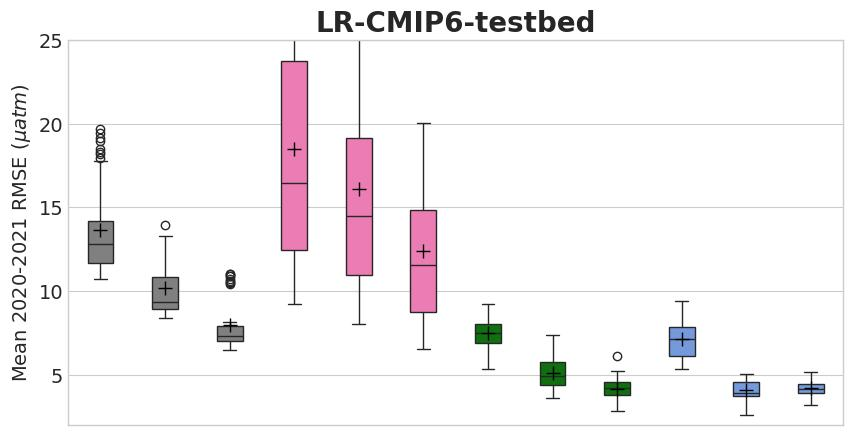

In [29]:
colors = ['gray', 'gray', 'gray','hotpink','hotpink', 'hotpink', 'green', 'green','green', 'cornflowerblue', 'cornflowerblue',  'cornflowerblue']
labels = ['', '','','','', '','','','','','','']

with plt.style.context('seaborn-v0_8-whitegrid'):
    fig = plt.figure(figsize=(10,5))

    sns.boxplot(data=[rmse_short_all_global.tolist(),rmse_full_all_global.tolist(),rmse_collapsed_all_global.tolist(),
                      rmse_short_all_bering.tolist(),rmse_full_all_bering.tolist(),rmse_collapsed_all_bering.tolist(),
                      rmse_short_all_gulf.tolist(),rmse_full_all_gulf.tolist(),rmse_collapsed_all_gulf.tolist(),
                      rmse_short_all_caribbean.tolist(),rmse_full_all_caribbean.tolist(),rmse_collapsed_all_caribbean.tolist()], 
            palette=colors, 
            showmeans=True, 
            width=0.4,
            meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "10"})

    plt.title('LR-CMIP6-testbed', fontsize= 20, weight='bold')
    plt.ylabel(f'Mean 2020-2021 RMSE ($\mu atm$)', fontsize = 14)
    plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11], fontsize = 12, labels = labels, weight='bold')
    plt.yticks(fontsize = 14)
    plt.ylim(2, 25)
#plt.savefig("/home/jovyan/boxplot_1x1resolution.jpg",dpi=300, bbox_inches="tight")